In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4

## World Ocean Atlas (WOA):

In [3]:
#Url to access the web:
url1 = 'https://www.ncei.noaa.gov/data/oceans/ncei/woa/oxygen/all/1.00/woa18_all_o00_01.nc'
#Url to access data from Python: 
url2 = 'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/oxygen/all/1.00/woa18_all_o00_01.nc'
ds = xr.open_dataset(url2, decode_times=False)

In [4]:
url_root = 'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/oxygen/all/1.00/'
file_name = 'woa18_all_o00_01.nc'
ds = xr.open_dataset(url_root+file_name, 
                     decode_times=False)

In [5]:
ds

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 8.214e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    o_an                (time, depth, lat, lon) float32 ...
    o_mn                (time, depth, lat, lon) float32 ...
    o_dd                (time, depth, lat, lon) float64 ...
    o_sd                (time, depth, lat, lon) float32 ...
    o_se                (time, depth, lat, lon) float32 ...
    o_oa                (time, depth, lat, lon) float32 ...
    o_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : mole_concentrat...
    summary:                         Climatological mean dissolved oxygen for...
    references:                      Garcia, H. E., K. Weathers, C. R. Paver,...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

In [6]:
for x in ds.variables.keys():
    if 'o_' in x:
        print(x, ds[x].long_name)

o_an Objectively analyzed mean fields for mole_concentration_of_dissolved_molecular_oxygen_in_sea_water at standard depth levels.
o_mn Average of all unflagged interpolated values at each standard depth level for mole_concentration_of_dissolved_molecular_oxygen_in_sea_water in each grid-square which contain at least one measurement.
o_dd The number of observations of mole_concentration_of_dissolved_molecular_oxygen_in_sea_water in each grid-square at each standard depth level.
o_sd The standard deviation about the statistical mean of mole_concentration_of_dissolved_molecular_oxygen_in_sea_water in each grid-square at each standard depth level.
o_se The standard error about the statistical mean of mole_concentration_of_dissolved_molecular_oxygen_in_sea_water in each grid-square at each standard depth level.
o_oa statistical mean value minus the objectively analyzed mean value for mole_concentration_of_dissolved_molecular_oxygen_in_sea_water.
o_gp The number of grid-squares within the sm

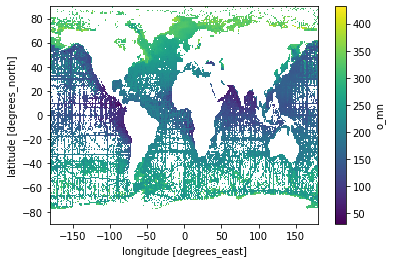

In [7]:
ds['o_mn'].mean(dim=['time','depth']).plot()

## World Ocean Data (WOD):

In [8]:
url_root = 'https://data.nodc.noaa.gov/thredds/dodsC/ncei/wod/'
year = 2018
file_name = '/wod_ctd_2018.nc'
ds2 = xr.open_dataset(url_root + str(year) + file_name, 
    decode_times=False)
ds2

<xarray.Dataset>
Dimensions:                         (casts: 22618, z_obs: 4129661, Temperature_obs: 4129636, Salinity_obs: 4089958, Oxygen_obs: 2566627, Chlorophyll_obs: 1604001, Pressure_obs: 3514144, Nitrate_obs: 17953, numberofpis: 140)
Coordinates:
    lat                             (casts) float32 ...
    lon                             (casts) float32 ...
    time                            (casts) float64 ...
    z                               (z_obs) float32 ...
Dimensions without coordinates: casts, z_obs, Temperature_obs, Salinity_obs, Oxygen_obs, Chlorophyll_obs, Pressure_obs, Nitrate_obs, numberofpis
Data variables: (12/75)
    country                         (casts) |S64 ...
    WOD_cruise_identifier           (casts) |S64 ...
    originators_cruise_identifier   (casts) |S64 ...
    wod_unique_cast                 (casts) int32 ...
    originators_station_identifier  (casts) |S64 ...
    date                            (casts) int32 ...
    ...                              ...
    Nitrate_WODprofileflag          (casts) int8 ...
    Nitrate_contains_nitrite        (casts) |S64 ...
    Primary_Investigator            (numberofpis) |S64 ...
    Primary_Investigator_VAR        (numberofpis) |S64 ...
    Primary_Investigator_row_size   (casts) float64 ...
    crs                             int32 ...
Attributes: (12/40)
    institution:                   National Centers for Environmental Informa...
    source:                        World Ocean Database
    references:                    World Ocean Database 2018. URL:http://data...
    title:                         World Ocean Database - Multi-cast file
    summary:                       Data for multiple casts from the World Oce...
    id:                            /nodc/data/OCLAB/OCL/retrieval/monthlies/w...
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v41
    featureType:                   Profile
    cdm_data_type:                 Profile
    Conventions:                   CF-1.6
    DODS.strlen:                   40
    DODS.dimName:                  strnlensmall

In [9]:
for x in ds2.keys():
    if 'Oxygen' in x:
        print(x, ds2[x].values.shape)
        
for x in ['lat', 'lon', 'time', 'z']:
    print(x, ds2[x].values.shape)

Oxygen (2566627,)
Oxygen_sigfigs (2566627,)
Oxygen_row_size (22618,)
Oxygen_WODflag (2566627,)
Oxygen_origflag (2566627,)
Oxygen_WODprofileflag (22618,)
Oxygen_Instrument (22618,)
Oxygen_Original_units (22618,)
lat (22618,)
lon (22618,)
time (22618,)
z (4129661,)


In [10]:
file_name = '/wod_pfl_2018.nc'
ds3 = xr.open_dataset(url_root + str(year) + file_name, 
    decode_times=False)
ds3.dims

Frozen({'casts': 176676, 'z_obs': 88925764, 'Temperature_obs': 88925621, 'Salinity_obs': 88904913, 'Pressure_obs': 88925764, 'Oxygen_obs': 9280272, 'Nitrate_obs': 4130029, 'pH_obs': 2333143, 'Chlorophyll_obs': 7991367, 'numberofpis': 205166})

In [11]:
for x in ds3.keys():
    if 'Oxygen' in x:
        print(x, ds3[x].values.shape)
        
for x in ['lat', 'lon', 'time', 'z']:
    print(x, ds3[x].values.shape)

Oxygen (9280272,)
Oxygen_sigfigs (9280272,)
Oxygen_row_size (176676,)
Oxygen_WODflag (9280272,)
Oxygen_origflag (9280272,)
Oxygen_WODprofileflag (176676,)
Oxygen_Adjustment (176676,)
Oxygen_prime_min_dep (176676,)
lat (176676,)
lon (176676,)
time (176676,)
z (88925764,)


In [12]:
np.nansum(ds3.Oxygen_row_size.values)

9280272.0

## Inspection Result: 
The sum of Oxygen_row_size is equal to the size of Oxygen. This implies that at each cast (lon, lat, time), there are multiple measurements for Oxygen. These measurements can be replication (more likely) or measurements at different depth (less likely because the shape of z is still unmatch). --> DONE

In [13]:
def rewrite_variable(ds3, var_name='Oxygen'):
    """
    Input: xarray data, name of the variable to rewrite
    Method: 
    - Loop through the row_size array. 
    - With each row size value, cut/trim the values from begining to begining+row size 
    - Append that cut/trimmed part to the var_rewrite_array
    Result: [array1,array2,array3...] where each array is the list of values for a given cast (lon, lat, time)
    """
    
    var_rewrite_array = []

    starting_index = 0
    for row_size in ds3[f'{var_name}_row_size'].values:
        if np.isnan(row_size): #Empty/No data
            var_rewrite_array.append([np.nan])
        else:
            ending_index = starting_index + int(row_size)
            var_rewrite_array.append(ds3[var_name].values[starting_index:ending_index])
            starting_index = ending_index
            
    return var_rewrite_array

In [14]:
ds3['Oxygen_row_size'].values[:10]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan, 558., 627.,  nan])

## Test the rewrite: 
IT WORKED!

In [15]:
oxygen_rewrite = rewrite_variable(ds3, var_name='Oxygen')
z_rewrite = rewrite_variable(ds3, var_name='z')

In [16]:
len(z_rewrite[7])

558

In [17]:
len(oxygen_rewrite[7])

558

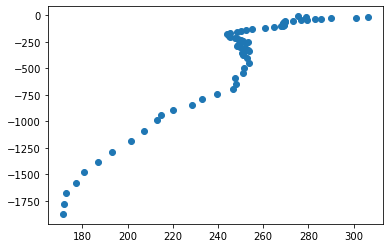

In [22]:
plt.scatter(oxygen_rewrite[7], -z_rewrite[7])
plt.show()

In [20]:
len(oxygen_rewrite[28])

1

In [16]:
median_oxygen_array = []

for x in oxygen_rewrite:
    if np.isnan(x).sum() == 1 and len(x) == 1:
        median_oxygen_array.append(np.nan)
    else:
        median_oxygen_array.append(np.median(x[~np.isnan(x)]))

In [20]:
import cartopy.crs as ccrs       # ccrs contains information about projections
import cartopy                   # contains all other cartopy functions/classes/methods
import cmocean

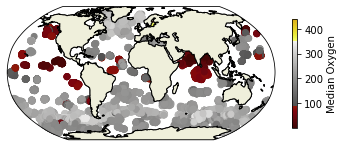

In [24]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()})
im = ax.scatter(ds3.lon.values, ds3.lat.values, c=median_oxygen_array, 
                transform=ccrs.PlateCarree(),cmap=cmocean.cm.oxy)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, edgecolor='black', zorder=1)
plt.colorbar(im, label='Median Oxygen', shrink=0.5)
fig.show()

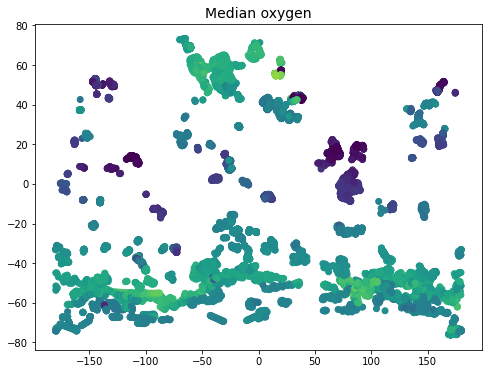

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(ds3.lon.values, ds3.lat.values, c=median_oxygen_array)
plt.title('Median oxygen', fontsize=14)
plt.show()

### WOD types of data: 
- xbt: temperature
- pfl: similar to ctd, but more data, still MISMATCH dimension
- osd: CTD + Ox + trace (alkalinity, isotope) + wind, usually available for old data
- mrb: CTD
- gld: CTD with Ox
- drb: CTD with Ox
- ctd: CTD with Ox
- apb: CTD 

Ocean Station
Data – OSD; High-resolution Conductivity-Temperature-Depth – CTD; Mechanical/ Digital/ Micro
Bathythermograph – MBT; Expendable Bathythermograph – XBT; Surface – SUR; Autonomous
Pinniped Bathythermograph – APB; Moored Buoy – MRB; Profiling Float – PFL; Drifting Buoy –DRB; 
Undulating Oceanographic Recorder – UOR; and Glider – GLD. In the remainder of this
document, the following terms OSD, CTD, MBT, XBT, SUR, APB, MRB, PFL, DRB, UOR, and
GLD are used. 

Data description: https://www.ncei.noaa.gov/sites/default/files/2020-04/wodreadme_0.pdf 

Mabye Oxygen is the result of the removing flagged data -> False -> SOLVED!
